# Анализ ошибок модели (Этап 6)

В этом разделе мы изучаем, где и почему модель ошибается:
- показываем объекты с наибольшими ошибками;
- смотрим распределение ошибок;
- анализируем ошибки по группам признаков (если доступны);
- формулируем идеи улучшения.


In [51]:
# Импорт библиотек и настройка окружения
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

plt.style.use('seaborn-v0_8')
sns.set_context('talk')


# Загрузка данных

Используем «чистый» датасет, подготовленный на прошлых этапах: `data/interim/kc_house_data_clean.csv`.


In [52]:
# Загрузка датасета
DATA_PATH = os.path.join('../', 'data', 'interim', 'kc_house_data_clean.csv')
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError('Не найден файл данных: data/interim/kc_house_data_clean.csv')

df = pd.read_csv(DATA_PATH)
print('Размерность данных:', df.shape)
print('Первые строки:')
print(df.head(3))


Размерность данных: (19269, 21)
Первые строки:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   

   sqft_lot15  
0        5650  
1 

# Выбор целевой переменной и признаков

Пытаемся определить целевую переменную автоматически:
- приоритет: `price`
- если нет, пробуем: `SalePrice`, `target`.

Признаки: числовые столбцы (исключая целевую и очевидные идентификаторы).


In [53]:
# Определяем целевую переменную
possible_targets = ['price', 'SalePrice', 'target']
target_col = None
for c in possible_targets:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError('Не удалось найти столбец целевой переменной (ожидались: price / SalePrice / target).')

print('Целевая переменная:', target_col)

# Идентификаторы, которые лучше исключить из признаков
id_like = [c for c in df.columns if c.lower() in ['id']]

# Выбираем числовые признаки
num_cols = df.select_dtypes(include=['number']).columns.tolist()
feature_cols = [c for c in num_cols if c != target_col and c not in id_like]

if len(feature_cols) == 0:
    raise ValueError('Не найдено числовых признаков для обучения.')

print('Количество признаков:', len(feature_cols))
print('Примеры признаков:', feature_cols[:10])

X = df[feature_cols].to_numpy()
y = df[target_col].to_numpy()


Целевая переменная: price
Количество признаков: 18
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']


# Тренировочно-тестовое разделение и быстрая модель

Чтобы получить предсказания (и ошибки), обучим быструю модель `RandomForestRegressor` с фиксированным `random_state`.


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Качество на тесте — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R^2: {r2:.4f}')


Качество на тесте — RMSE: 94,056.78 | MAE: 59,302.95 | R^2: 0.8683


# Остатки и абсолютные ошибки

- Остаток: `y_true - y_pred`.
- Абсолютная ошибка: `|y_true - y_pred|`.

Посмотрим распределение ошибок и Топ-10 наихудших примеров.


In [55]:
residuals = y_test - y_pred
abs_errors = np.abs(residuals)

err_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'residual': residuals,
    'abs_error': abs_errors
})

print('Топ-10 объектов с наибольшей абсолютной ошибкой:')
print(err_df.sort_values('abs_error', ascending=False).head(10))


Топ-10 объектов с наибольшей абсолютной ошибкой:
         y_true        y_pred       residual      abs_error
468   1575000.0  7.764126e+05  798587.373333  798587.373333
2503  1600000.0  8.827032e+05  717296.793333  717296.793333
1388  1550000.0  8.350994e+05  714900.563333  714900.563333
823   1200000.0  6.060011e+05  593998.930000  593998.930000
961   1000000.0  4.107580e+05  589242.006667  589242.006667
1919  1247000.0  6.586398e+05  588360.193333  588360.193333
1396  1075000.0  4.945315e+05  580468.500000  580468.500000
3672  1580000.0  1.011418e+06  568582.200000  568582.200000
2616  1280000.0  7.205843e+05  559415.650000  559415.650000
1684  1517000.0  9.605847e+05  556415.336667  556415.336667


# Визуализации ошибок

1) Гистограмма абсолютных ошибок.
2) Диаграмма «Истинные vs Предсказанные».
3) Ошибка в зависимости от истинной цены (если целевая — цена).



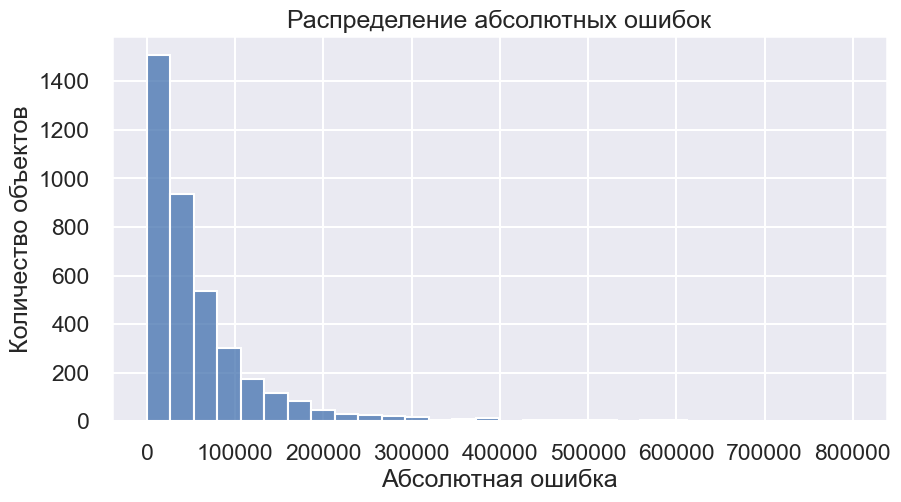

In [56]:
# Гистограмма абсолютных ошибок
plt.figure(figsize=(10, 5))
sns.histplot(abs_errors, bins=30, color='#4271AE')
plt.title('Распределение абсолютных ошибок')
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Количество объектов')
plt.show()

Основная масса прогнозов имеет ошибку менее ~100k — модель в целом предсказывает адекватно для большинства объектов.

Есть длинный «хвост» крупных ошибок (до 800k), что указывает на проблемы с дорогими/редкими объектами.

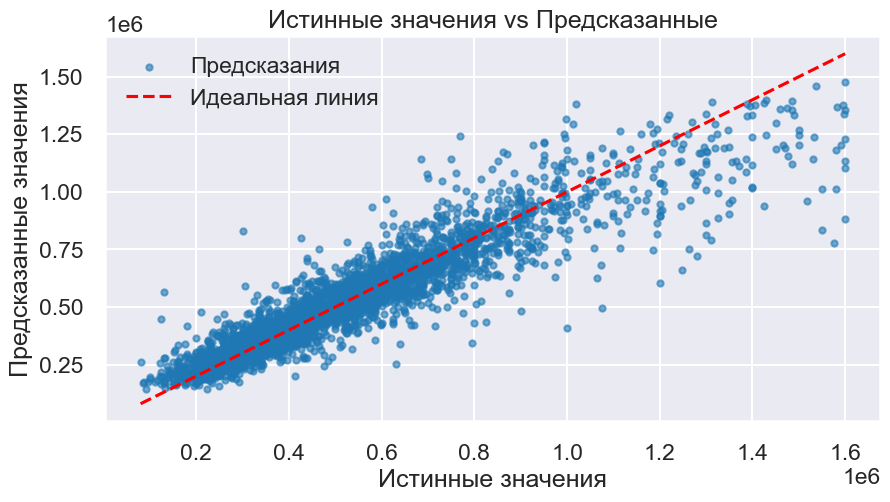

In [57]:
# Истинные vs Предсказанные
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20, alpha=0.6, color='#1F78B4', label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Идеальная линия')
plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend(loc='best')
plt.show()

Точки в целом лежат вдоль диагонали — модель улавливает основные закономерности цен.

В правой части заметно отклонение вниз — дорогие дома модель недооценивает, что подтверждает проблему с high-end сегментом.

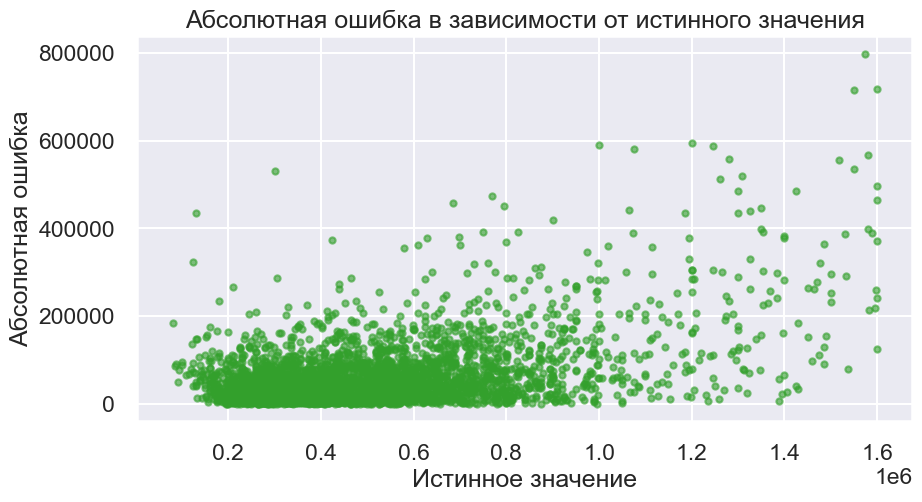

In [58]:
# Ошибка vs Истинная цена
plt.figure(figsize=(10, 5))
plt.scatter(y_test, abs_errors, s=20, alpha=0.6, color='#33A02C')
plt.title('Абсолютная ошибка в зависимости от истинного значения')
plt.xlabel('Истинное значение')
plt.ylabel('Абсолютная ошибка')
plt.show()

Модель хуже всего предсказывает дорогие дома — для них наблюдаются наибольшие ошибки (до 800 000). Это связано с малым количеством таких объектов в данных и сложностью зависимостей в премиум-сегменте.

# Групповой анализ ошибок

Если в данных есть категориальные или дискретные признаки (например, количество спален `bedrooms`), посмотрим среднюю абсолютную ошибку по группам.

Если такого признака нет — изучим ошибки по квантилям целевой переменной.


Группируем по признаку: bedrooms
Статистика ошибок по группам:
   group  count           mean        median
0      1     25   89644.118889  61360.066667
1      2    530   55148.295485  37069.136667
2      3   1798   53947.820607  34236.457222
3      4   1195   62794.960803  37979.566667
4      5    259   79593.934068  52565.506667
5      6     42   90669.263228  55140.310556
6      7      5  124556.858000  57593.750000


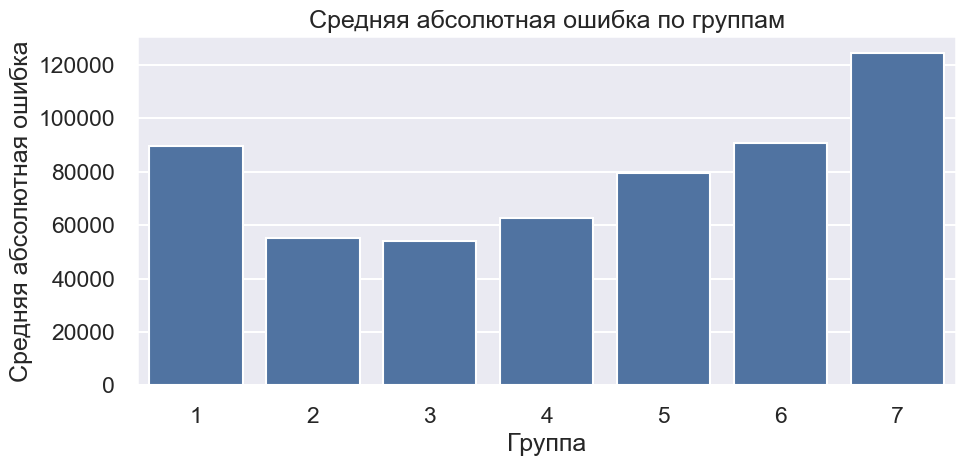

In [59]:
# Пытаемся найти разумный дискретный признак
candidate_group_cols = [
    c for c in df.columns if c in ['bedrooms', 'bathrooms', 'floors']
]

if len(candidate_group_cols) > 0:
    group_col = candidate_group_cols[0]
    print(f'Группируем по признаку: {group_col}')

    # Восстановим индексы тестовой выборки — создаём маску test
    _, X_test_idx = train_test_split(
        np.arange(df.shape[0]), test_size=0.2, random_state=RANDOM_STATE
    )

    groups = df.iloc[X_test_idx][group_col].values
    grp_df = pd.DataFrame({'group': groups, 'abs_error': abs_errors})
    grp_stats = grp_df.groupby('group')['abs_error'].agg(['count', 'mean', 'median']).reset_index()
    print('Статистика ошибок по группам:')
    print(grp_stats)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=grp_stats, x='group', y='mean', color='#4271AE')
    plt.title('Средняя абсолютная ошибка по группам')
    plt.xlabel('Группа')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.tight_layout()
    plt.show()
else:
    print('Не найден подходящий дискретный признак, используем квантильный анализ целевой переменной.')
    # Квантильный анализ целевой для теста
    q = pd.qcut(y_test, q=5, duplicates='drop')
    qa_df = pd.DataFrame({'target_quantile': q, 'abs_error': abs_errors})
    qa_stats = qa_df.groupby('target_quantile')['abs_error'].agg(['count', 'mean', 'median']).reset_index()
    print('Статистика ошибок по квантилям целевой переменной:')
    print(qa_stats)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=qa_stats, x='target_quantile', y='mean', color='#4271AE')
    plt.title('Средняя абсолютная ошибка по квантилям целевой переменной')
    plt.xlabel('Квантиль целевой')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


Модель наиболее точно предсказывает цены для домов с 2-3 спальнями (средняя ошибка ~55-54 тыс.). Для объектов с 1 спальней или 5+ спален ошибки значительно выше (до 124 тыс. для 7 спален). Это связано с недостатком данных для нетипичных конфигураций — дома с 2-4 спальнями составляют большинство выборки, поэтому модель лучше обучена на них.

Рекомендация: Для улучшения прогнозов по редким категориям (1, 5+ спален) требуется либо сбор дополнительных данных, либо применение методов, лучше работающих на малых выборках.

# Дополнительный анализ ошибок: конкретные примеры и проверка гипотез
Теперь проанализируем конкретные дома с наибольшими ошибками и проверим наши гипотезы.

Анализ самых больших ошибок

Топ-5 домов с самыми большими ошибками:


,№,Ошибка ($),Ошибка (%),Реальная цена ($),Предсказанная ($),Направление,Спальни,Ванные,Площадь,Качество
0,1,"$798,587",50.7%,"$1,575,000","$776,413",Занизила,3,3,2610,8
1,2,"$717,297",44.8%,"$1,600,000","$882,703",Занизила,4,2,2940,9
2,3,"$714,901",46.1%,"$1,550,000","$835,099",Занизила,3,3,3530,9
3,4,"$593,999",49.5%,"$1,200,000","$606,001",Занизила,3,2,2480,7
4,5,"$589,242",58.9%,"$1,000,000","$410,758",Занизила,3,1,1540,7


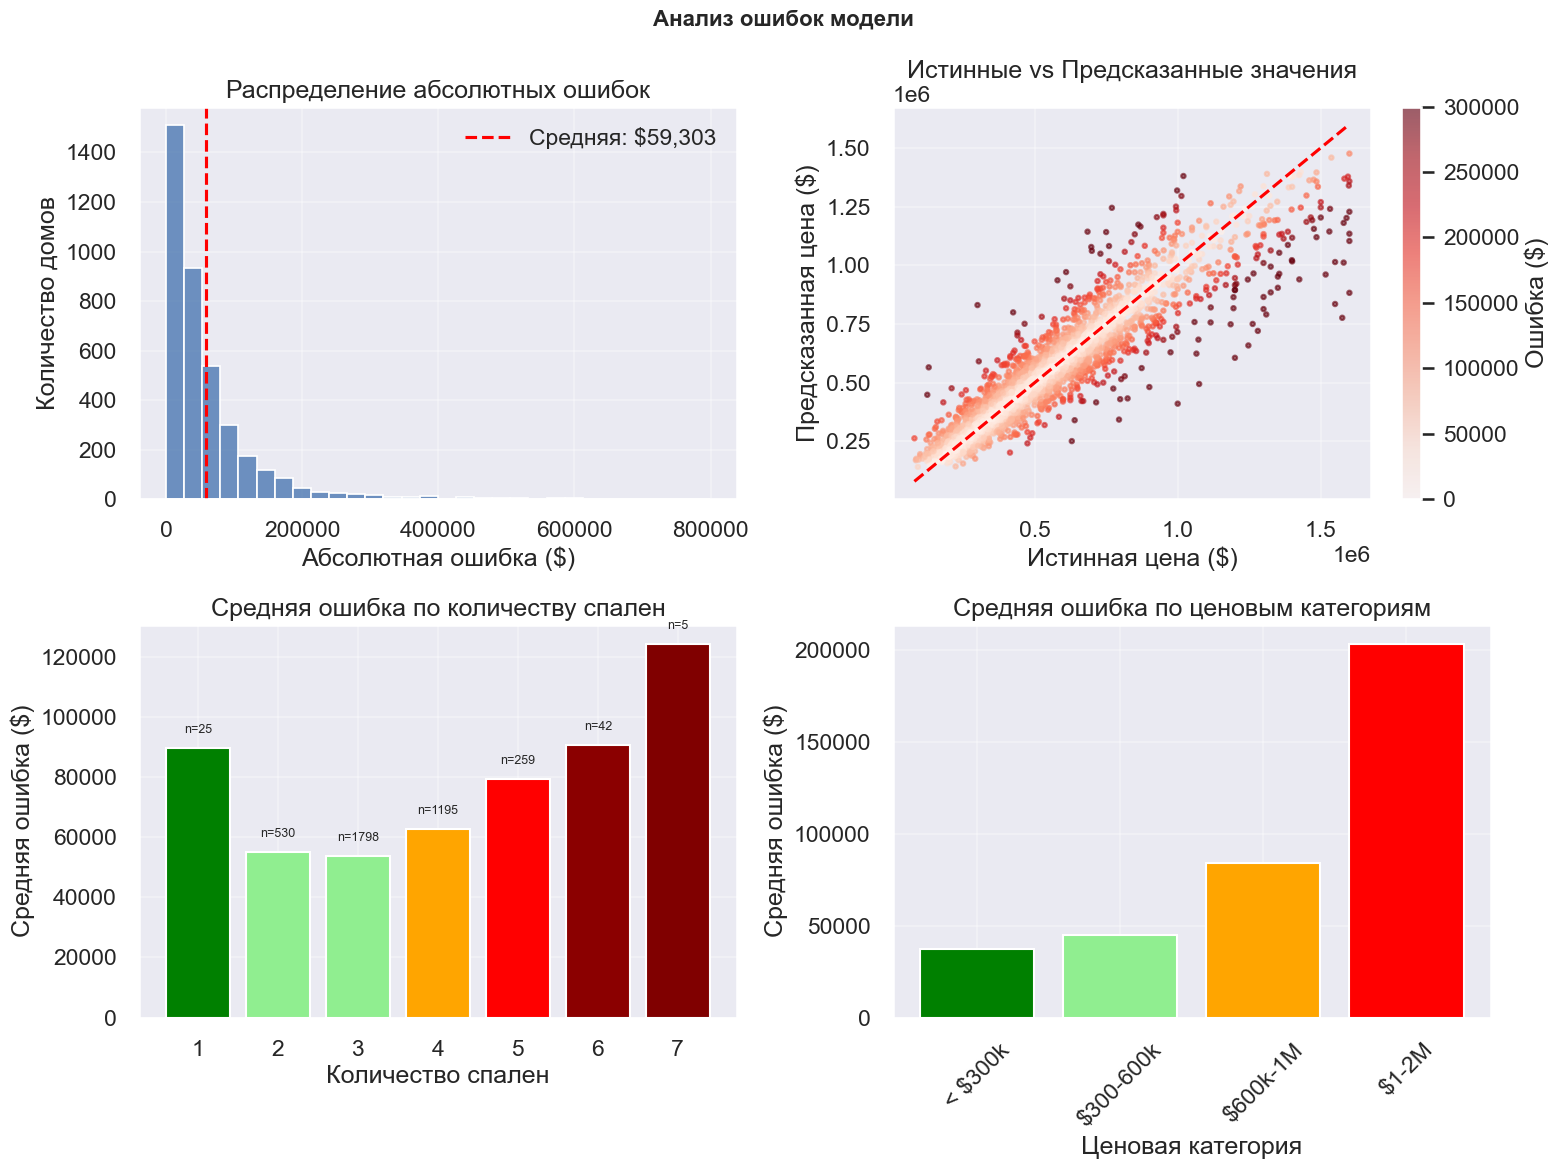

ПРОВЕРКА ГИПОТЕЗ

Проверка гипотез:


,Гипотеза,Проверка,Результат,Коэффициент
0,Модель хуже предсказывает дорогие дома (>$1M),"Дорогие: $203,258 vs Обычные: 39911",✓ Подтверждена,5.09
1,Дома с видом на воду предсказываются хуже,"С водой: 335,455 vs Без воды:58,440",✓ Подтверждена,5.74
2,Дома с 5+ спальнями предсказываются хуже,"5+ спален: 81,849 vs 1-3 спальни: 54,597",✓ Подтверждена,1.50


КЛЮЧЕВЫЕ МЕТРИКИ ОШИБОК


,Метрика,Числовое значение
0,Средняя абсолютная ошибка (MAE),"$59,303"
1,Корень из MSE (RMSE),"$94,057"
2,Коэффициент детерминации (R²),0.868
3,Максимальная ошибка,"$798,587"
4,75% домов имеют ошибку ≤,"$74,920"
5,90% домов имеют ошибку ≤,"$134,891"
6,Средняя ошибка для домов >1M,"$203,258"
7,Средняя ошибка для домов <500K,"$39,911"


РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ


,Приоритет,Рекомендация,Ожидаемый эффект
0,Высокий,Использовать логарифм цены вместо обычной,Уменьшит влияние очень дорогих домов
1,Высокий,Создать отдельную модель для домов дороже $1M,Улучшит точность для премиум-сегмента
2,Средний,"Добавить признак ""цена за кв.фут""",Улучшит сравнение домов разного размера
3,Средний,Сгруппировать почтовые индексы в районы,Учтет локационные особенности
4,Низкий,"Проверить данные домов с ошибками > $500,000",Исключит ошибки в данных


In [60]:

# 1. Анализ топ-5 ошибок с таблицей
print("Анализ самых больших ошибок")

# Создаем таблицу с топ-5 ошибок
top_errors = err_df.nlargest(5, 'abs_error').copy()
top_errors_data = []

for i, (idx, row) in enumerate(top_errors.iterrows()):
    original_idx = X_test_idx[idx]
    house = df.iloc[original_idx]

    top_errors_data.append({
        '№': i+1,
        'Ошибка ($)': row['abs_error'],
        'Ошибка (%)': (row['abs_error']/row['y_true']*100),
        'Реальная цена ($)': row['y_true'],
        'Предсказанная ($)': row['y_pred'],
        'Направление': 'Занизила' if row['y_pred'] < row['y_true'] else 'Завысила',
        'Спальни': int(house['bedrooms']),
        'Ванные': int(house['bathrooms']),
        'Площадь': int(house['sqft_living']),
        'Качество': int(house['grade'])
    })

# Создаем DataFrame и форматируем его
top_errors_df = pd.DataFrame(top_errors_data)

# Форматируем для красивого вывода
def format_currency(x):
    """Форматирует числа как валюту"""
    try:
        return f"${x:,.0f}"
    except:
        return x

def format_percent(x):
    """Форматирует проценты"""
    try:
        return f"{x:.1f}%"
    except:
        return x

# Создаем стилизованную таблицу
styled_top_errors = top_errors_df.style \
    .format({
        'Ошибка ($)': format_currency,
        'Реальная цена ($)': format_currency,
        'Предсказанная ($)': format_currency,
        'Ошибка (%)': format_percent
    }) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4CAF50'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('padding', '10px')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
    ])

print("\nТоп-5 домов с самыми большими ошибками:")
display(styled_top_errors)

# 2. Создаем датафрейм для анализа
analysis_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'residual': residuals,
    'abs_error': abs_errors,
    'bedrooms': df.iloc[X_test_idx]['bedrooms'].values,
    'sqft_living': df.iloc[X_test_idx]['sqft_living'].values,
    'grade': df.iloc[X_test_idx]['grade'].values,
    'waterfront': df.iloc[X_test_idx]['waterfront'].values if 'waterfront' in df.columns else 0
})

# 3. Визуализация в одном окне
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ ошибок модели', fontsize=16, fontweight='bold')

# График 1: Распределение ошибок
sns.histplot(abs_errors, bins=30, ax=axes[0, 0], color='#4271AE')
axes[0, 0].axvline(x=abs_errors.mean(), color='red', linestyle='--',
                   label=f'Средняя: ${abs_errors.mean():,.0f}')
axes[0, 0].set_title('Распределение абсолютных ошибок')
axes[0, 0].set_xlabel('Абсолютная ошибка ($)')
axes[0, 0].set_ylabel('Количество домов')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# График 2: Истинные vs Предсказанные
scatter = axes[0, 1].scatter(y_test, y_pred, s=10, alpha=0.6, c=abs_errors,
                             cmap='Reds', vmin=0, vmax=300000)
axes[0, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', label='Идеально')
axes[0, 1].set_title('Истинные vs Предсказанные значения')
axes[0, 1].set_xlabel('Истинная цена ($)')
axes[0, 1].set_ylabel('Предсказанная цена ($)')
plt.colorbar(scatter, ax=axes[0, 1], label='Ошибка ($)')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Ошибки по количеству спален
bedroom_stats = analysis_df.groupby('bedrooms')['abs_error'].agg(['count', 'mean']).reset_index()
bedroom_stats = bedroom_stats[bedroom_stats['bedrooms'] <= 7]
axes[1, 0].bar(bedroom_stats['bedrooms'], bedroom_stats['mean'],
               color=['green', 'lightgreen', 'lightgreen', 'orange', 'red', 'darkred', 'maroon'])
axes[1, 0].set_title('Средняя ошибка по количеству спален')
axes[1, 0].set_xlabel('Количество спален')
axes[1, 0].set_ylabel('Средняя ошибка ($)')
axes[1, 0].set_xticks(range(1, 8))
axes[1, 0].grid(True, alpha=0.3)

# Добавляем подписи
for i, row in bedroom_stats.iterrows():
    axes[1, 0].text(row['bedrooms'], row['mean'] + 5000,
                   f"n={int(row['count'])}", ha='center', fontsize=9)

# График 4: Ошибки по ценовым категориям
price_bins = [0, 300000, 600000, 1000000, 2000000, float('inf')]
price_labels = ['< $300k', '$300-600k', '$600k-1M', '$1-2M', '> $2M']
analysis_df['price_category'] = pd.cut(analysis_df['y_true'], bins=price_bins, labels=price_labels)
price_stats = analysis_df.groupby('price_category', observed=False)['abs_error'].mean()

axes[1, 1].bar(price_stats.index, price_stats.values,
               color=['green', 'lightgreen', 'orange', 'red', 'darkred'])
axes[1, 1].set_title('Средняя ошибка по ценовым категориям')
axes[1, 1].set_xlabel('Ценовая категория')
axes[1, 1].set_ylabel('Средняя ошибка ($)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Сводная таблица с проверкой гипотез
print("ПРОВЕРКА ГИПОТЕЗ")

# Создаем таблицу для гипотез
hypotheses_data = []

# Гипотеза 1: Дорогие дома
expensive_mask = analysis_df['y_true'] > 1000000
cheap_mask = analysis_df['y_true'] < 500000

if expensive_mask.any() and cheap_mask.any():
    expensive_error = analysis_df.loc[expensive_mask, 'abs_error'].mean()
    cheap_error = analysis_df.loc[cheap_mask, 'abs_error'].mean()
    ratio = expensive_error / cheap_error

    hypotheses_data.append({
        'Гипотеза': 'Модель хуже предсказывает дорогие дома (>$1M)',
        'Проверка': f"Дорогие: ${expensive_error:,.0f} vs Обычные: {cheap_error:.0f}",
        'Результат': '✓ Подтверждена' if ratio > 1.5 else '✗ Частично',
        'Коэффициент': ratio
    })

# Гипотеза 2: Вид на воду
if 'waterfront' in df.columns:
    waterfront_error = analysis_df.loc[analysis_df['waterfront'] == 1, 'abs_error'].mean()
    non_waterfront_error = analysis_df.loc[analysis_df['waterfront'] == 0, 'abs_error'].mean()
    if pd.notna(waterfront_error) and non_waterfront_error > 0:
        ratio = waterfront_error / non_waterfront_error

        hypotheses_data.append({
            'Гипотеза': 'Дома с видом на воду предсказываются хуже',
            'Проверка': f"С водой: {waterfront_error:,.0f} vs Без воды:{non_waterfront_error:,.0f}",
            'Результат': '✓ Подтверждена' if ratio > 1.2 else '✗ Не подтверждена',
            'Коэффициент': ratio
        })

# Гипотеза 3: Большие дома
big_houses_error = analysis_df.loc[analysis_df['bedrooms'] >= 5, 'abs_error'].mean()
small_houses_error = analysis_df.loc[analysis_df['bedrooms'] <= 3, 'abs_error'].mean()
if pd.notna(big_houses_error) and pd.notna(small_houses_error) and small_houses_error > 0:
    ratio = big_houses_error / small_houses_error

    hypotheses_data.append({
        'Гипотеза': 'Дома с 5+ спальнями предсказываются хуже',
        'Проверка': f"5+ спален: {big_houses_error:,.0f} vs 1-3 спальни: {small_houses_error:,.0f}",
        'Результат': '✓ Подтверждена' if ratio > 1.3 else '✗ Частично',
        'Коэффициент': ratio
    })

# Создаем DataFrame
hypotheses_df = pd.DataFrame(hypotheses_data)

# Стилизуем таблицу
def color_result(val):
    if '✓' in str(val):
        return 'color: green; font-weight: bold'
    else:
        return 'color: orange'

styled_hypotheses = hypotheses_df.style \
    .map(color_result, subset=['Результат']) \
    .format({'Коэффициент': '{:.2f}'}) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#2196F3'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('padding', '10px')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#e3f2fd')]}
    ])

print("\nПроверка гипотез:")
display(styled_hypotheses)

# 5. Ключевые метрики в виде таблицы
print("КЛЮЧЕВЫЕ МЕТРИКИ ОШИБОК")

metrics_data = {
    'Метрика': [
        'Средняя абсолютная ошибка (MAE)',
        'Корень из MSE (RMSE)',
        'Коэффициент детерминации (R²)',
        'Максимальная ошибка',
        '75% домов имеют ошибку ≤',
        '90% домов имеют ошибку ≤',
        'Средняя ошибка для домов >1M',
        'Средняя ошибка для домов <500K'
    ],
    'Числовое значение': [
        mae,
        rmse,
        r2,
        abs_errors.max(),
        np.percentile(abs_errors, 75),
        np.percentile(abs_errors, 90),
        analysis_df.loc[analysis_df['y_true'] > 1000000, 'abs_error'].mean(),
        analysis_df.loc[analysis_df['y_true'] < 500000, 'abs_error'].mean()
    ]
}

metrics_df = pd.DataFrame(metrics_data)

# Функция для форматирования
def format_metric(val):
    if isinstance(val, (int, float)):
        if val > 1000:  # Деньги
            return f"${val:,.0f}"
        elif 0 <= val <= 1:  # Проценты/коэффициенты
            return f"{val:.3f}"
        else:
            return f"{val:,.0f}"
    return val

styled_metrics = metrics_df.style \
    .format({'Числовое значение': format_metric}) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#FF9800'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('padding', '10px')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#fff3e0')]}
    ])

display(styled_metrics)

# 6. Рекомендации в виде таблицы
print("РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ")

recommendations_data = {
    'Приоритет': ['Высокий', 'Высокий', 'Средний', 'Средний', 'Низкий'],
    'Рекомендация': [
        'Использовать логарифм цены вместо обычной',
        'Создать отдельную модель для домов дороже $1M',
        'Добавить признак "цена за кв.фут"',
        'Сгруппировать почтовые индексы в районы',
        'Проверить данные домов с ошибками > $500,000'
    ],
    'Ожидаемый эффект': [
        'Уменьшит влияние очень дорогих домов',
        'Улучшит точность для премиум-сегмента',
        'Улучшит сравнение домов разного размера',
        'Учтет локационные особенности',
        'Исключит ошибки в данных'
    ]
}

recommendations_df = pd.DataFrame(recommendations_data)

# Функция для цветового кодирования приоритета
def color_priority(val):
    if val == 'Высокий':
        return 'background-color: #ff4444; color: white; font-weight: bold'
    elif val == 'Средний':
        return 'background-color: #ffbb33; color: black; font-weight: bold'
    else:
        return 'background-color: #00C851; color: white; font-weight: bold'

styled_recommendations = recommendations_df.style \
    .map(color_priority, subset=['Приоритет']) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#9C27B0'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('padding', '10px')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f3e5f5')]}
    ])

display(styled_recommendations)

## Общий вывод по анализу ошибок

## Краткая сводка
- Общая точность: MAE = $59,303; RMSE = $94,057; R² = 0.868.
- Распределение ошибок: 75% ≤ 74,920 долларов; 90% ≤ 134,891 долларов; max = 798,587.
- Хвосты: для домов > 1M долларов средняя ошибка ≈ 203,258 долларов (≈5× больше, чем для <500K).

## Основные проблемы (факты)
- Модель систематически недооценивает дорогие объекты (гетероскедастичность — residuals растут с ценой).
- В верхнем хвосте мало репрезентативных примеров — модель не видела достаточно подобных лотов.
- Ключевые премиум‑фичи (waterfront, view, микро‑локация, реконструкция и т.п.) представлены слабо или отсутствуют.
- Обучение на сырых ценах усиливает влияние выбросов и смещает оптимизацию в сторону средних значений.

## Практическая интерпретация
- Модель пригодна для массового сегмента: прогнозы в центре распределения стабильны.
- Для оценки отдельных элитных лотов модель ненадёжна — высокий риск крупных недооценок/переоценок.

## Приоритетные рекомендации (самое важное)
1. Обучать на log1p(price) (лог‑таргет) — быстро снизит влияние дорогих выбросов.
2. Сделать отдельную модель или модель остатков для домов > $1M (Mixture of Experts / двухступенчатая схема).
3. По возможности добавить премиум‑фичи: price_per_sqft, neighborhood aggregates, waterfront/view, interaction‑признаки.